In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import torchaudio
import os
import subprocess
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# --------------------------
# 1) Network
# --------------------------
class XYSpecNet(nn.Module):
    def __init__(self, spec_dim=64, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + spec_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 3),
            nn.Sigmoid()
        )
    
    def forward(self, xy_spec):
        return self.net(xy_spec)

In [3]:
# --------------------------
# 2) Parameters
# --------------------------
H, W = 256, 256
hidden = 64
latent_size = 64 #Number of frequency bins in the Mel spectrogram.
target_fps = 30 #Target video frame rate (frames per second).
target_img_path = "target.png"

# --------------------------
# 3) Coordinate grid (normalized)
# --------------------------
xs = torch.linspace(-1, 1, W)
ys = torch.linspace(-1, 1, H)
xx, yy = torch.meshgrid(xs, ys, indexing='xy')
coords = torch.stack([xx.flatten(), yy.flatten()], dim=1)

In [4]:
# --------------------------
# STAGE 1: Train on target image with ALL spectrogram frames
# --------------------------
print("\n=== Stage 1: Training network on reference image ===")

# Load all audio and compute spectrogram ONCE
audio_path = "audio.wav"
audio, sr = torchaudio.load(audio_path, normalize=True) 
# audio:amplitude over time, sr: sample rate, eg: 44100 (samples per second)
audio = audio[0] # only take first channel (Left channel)
hop_length = int(sr / target_fps) # number of audio samples to skip between consecutive spectrogram

transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=hop_length * 2,
    n_mels=latent_size,
    hop_length=hop_length,
    win_length=hop_length * 2
)
spectrogram = transform(audio).T

spectrogram = torch.log(spectrogram + 1e-9)  # Log scale helps with sparsity
spec_min = spectrogram.min()
spec_max = spectrogram.max()
spectrogram = (spectrogram - spec_min) / (spec_max - spec_min + 1e-8)  # Normalize to [0, 1]

print(f'Spectrogram shape: {spectrogram.shape}')
print(f'Spectrogram range: {spectrogram.min():.6f} to {spectrogram.max():.6f}')
print(f'Mean: {spectrogram.mean():.6f}, Std: {spectrogram.std():.6f}')

# Load target image
target_img = Image.open(target_img_path).convert("RGB").resize((W, H))
target_rgb = np.asarray(target_img, dtype=np.float32) / 255.0
target_tensor = torch.from_numpy(target_rgb.reshape(-1, 3))

model = XYSpecNet(spec_dim=latent_size, hidden=hidden)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


=== Stage 1: Training network on reference image ===
Spectrogram shape: torch.Size([96, 64])
Spectrogram range: 0.000000 to 1.000000
Mean: 0.393003, Std: 0.161755


Step 0, loss=0.107029
Step 100, loss=0.040873
Step 200, loss=0.033084
Step 300, loss=0.024047
Step 400, loss=0.018201
Training complete!


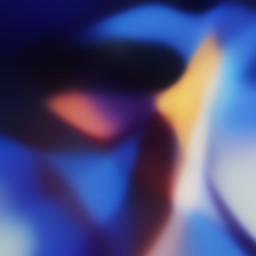

Training complete!



In [5]:
# Sample frames from spectrogram for training (can use all or subset)

# Pick 50 random indices from 0 to len(spectrogram)-1, no duplicates.
train_frame_indices = np.random.choice(len(spectrogram), size=min(50, len(spectrogram)), replace=False)
train_specs = spectrogram[train_frame_indices]  # Shape: [num_train_frames, latent_size]

for step in range(500):
    optimizer.zero_grad()
    
    # select different frame each time
    idx = np.random.randint(0, len(train_specs))
    spec_frame = train_specs[idx]
    
    # Tile spectrogram
    music_vec = spec_frame.unsqueeze(0).repeat(H * W, 1)
    inp_train = torch.cat([coords, music_vec], dim=1)
    
    pred = model(inp_train)
    loss = loss_fn(pred, target_tensor)
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print(f"Step {step}, loss={loss.item():.6f}")

print("Training complete!")
with torch.no_grad():
    trained_img = model(inp_train).reshape(H, W, 3).numpy()
    display(Image.fromarray((trained_img * 255).astype(np.uint8)))


print("Training complete!\n")

In [6]:
# --------------------------
# STAGE 2: Generate frames with ALL audio files
# --------------------------
def generate_video_from_audio(audio_file, output_name):
    print(f"\n=== Generating video for {audio_file} ===")
    
    # Load and process audio
    audio, sr = torchaudio.load(audio_file, normalize=True)
    audio = audio[0]
    hop_length = int(sr / target_fps)
    
    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=hop_length * 2,
        n_mels=latent_size,
        hop_length=hop_length,
        win_length=hop_length * 2
    )
    
    spec = transform(audio).T
    
    # Apply SAME normalization as training
    spec = torch.log(spec + 1e-9)
    spec = (spec - spec_min) / (spec_max - spec_min + 1e-8)
    
    print(f"Spectrogram shape: {spec.shape}")
    
    # Generate frames

    # Create folder name. If output_name = "audio1", then output_dir = "frames_audio1".
    output_dir = f"frames_{output_name}"
    # `os.makedirs()` creates directory
    # `exist_ok=True` means if folder already exists, don't error (just skip)
    os.makedirs(output_dir, exist_ok=True)

    # Get number of frames in spectrogram.
    num_frames = spec.shape[0]
    # Set model to evaluation mode, disables training-specific behaviors.
    model.eval()
    
    with torch.no_grad():
        for f in range(num_frames):
            spec_frame = spec[f]
            spec_tiled = spec_frame.unsqueeze(0).repeat(H * W, 1)
            inp_frame = torch.cat([coords, spec_tiled], dim=1)
            rgb = model(inp_frame).reshape(H, W, 3).cpu().numpy()

            # Create file path for frame.
            # `f:06d` formats number with 6 digits, zero-padded
            # Example: f=0 → "000000.png", f=123 → "000123.png"
            frame_path = os.path.join(output_dir, f"{f:06d}.png")

            img = Image.fromarray((rgb * 255).astype(np.uint8))
            img.save(frame_path)
            
            if (f + 1) % 50 == 0:
                print(f"  Saved {f + 1}/{num_frames} frames")
    
    # Create video
    print("Creating video...")
    output_video = f"{output_name}.mp4"

    # This builds an ffmpeg command to convert frames into video.
    ffmpeg_cmd = [
        'ffmpeg', '-y', #-y: Overwrite output file if it exists 
        '-framerate', str(target_fps), # Input frame rate (30 fps).
        '-i', os.path.join(output_dir, '%06d.png'), # read PNG sequence.
        '-c:v', 'libx264', # Video codec. Use H.264 compression (algorithm that compresses video).
        '-pix_fmt', 'yuv420p', # Pixel format. YUV420P is compatible with most players. Pixel format is how colors are stored in video data.
        output_video
    ]
    # check = TRUE: If ffmpeg returns error, raise exception and stop (don't ignore errors).
    # capture_output=True: don't print ffmpeg's messages to console.
    subprocess.run(ffmpeg_cmd, check=True, capture_output=True)
    
    # Add audio
    print("Adding audio...")
    output_final = f"{output_name}_final.mp4"
    ffmpeg_audio_cmd = [
        'ffmpeg', '-y',
        '-i', output_video, # Input 1: video file (without audio).
        '-i', audio_file, # Input 2: audio file.
        '-c:v', 'copy', # Video codec: copy (don't re-encode, fast).
        '-c:a', 'aac', # Audio codec: AAC (compress audio).
        '-map', '0:v:0', # Map: take video stream from input 0.
        '-map', '1:a:0', # Map: take audio stream from input 1.
        '-shortest', # Stop when shorter stream ends (video and audio sync).
        output_final
    ]
    subprocess.run(ffmpeg_audio_cmd, check=True, capture_output=True)
    
    # Cleanup
    import shutil
    shutil.rmtree(output_dir, ignore_errors=True) # Delete entire folder and all files inside.
    os.remove(output_video) # Delete the temporary MP4 file.
    
    print(f"✓ Video saved: {output_final}\n")

# Generate videos for all audio files
audio_files = ["audio3.wav", "audio2.wav", "audio1.wav"]
for audio_file in audio_files:
    if os.path.exists(audio_file):
        output_name = audio_file.replace('.wav', '')
        generate_video_from_audio(audio_file, output_name)
    else:
        print(f"Warning: {audio_file} not found")


=== Generating video for audio3.wav ===
Spectrogram shape: torch.Size([601, 64])
  Saved 50/601 frames
  Saved 100/601 frames
  Saved 150/601 frames
  Saved 200/601 frames
  Saved 250/601 frames
  Saved 300/601 frames
  Saved 350/601 frames
  Saved 400/601 frames
  Saved 450/601 frames
  Saved 500/601 frames
  Saved 550/601 frames
  Saved 600/601 frames
Creating video...
Adding audio...
✓ Video saved: audio3_final.mp4


=== Generating video for audio2.wav ===
Spectrogram shape: torch.Size([384, 64])
  Saved 50/384 frames
  Saved 100/384 frames
  Saved 150/384 frames
  Saved 200/384 frames
  Saved 250/384 frames
  Saved 300/384 frames
  Saved 350/384 frames
Creating video...
Adding audio...
✓ Video saved: audio2_final.mp4


=== Generating video for audio1.wav ===
Spectrogram shape: torch.Size([358, 64])
  Saved 50/358 frames
  Saved 100/358 frames
  Saved 150/358 frames
  Saved 200/358 frames
  Saved 250/358 frames
  Saved 300/358 frames
  Saved 350/358 frames
Creating video...
Adding 